# Problem Statement

Through analyzing this datasset for Search and Rescue missions, what appear to be the key factors that indicate the timeframe to locate and rescue victims both in wilderness and non-wilderness environments?

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

np.random.seed(23)

In [2]:
rel_path = '../Data/MRA_Mission_Data_Archive_Public_View_for_Open_Data_2013-2020.csv'
df = pd.read_csv(rel_path, low_memory=False)

# Initial Data Cleanup
- lower_snake_case columns
- drop features that are not indicators of `time` target

|Variable|Description
|:--|:--|
|**incident_number**|Non-standard identifier for incident|
|**objectid**|Unique identifier for datapoint in dataset|
|**globalid**|Geo location identifier (format unrocognized)|
|**team_not_listed**|100% null|
|**number_tm_injured**|Number of SAR team injured during incident|
|**level_of_care_rescuer**|Level of medical care for rescuer|
|**medical_problems_team_member**|Team member medical problems cause by incident|
|**medical_problems_other_team_member**|Team member medical problems cause by incident|
|**creationdate**|Date the datapoint was entered into database|
|**creator**|Identifier for entity recording datapoint|
|**editdate**|Date of edit correction to datapoint|
|**editor**|Identifier for entity editing datapoint|
|**incident_uuid**|100% null|
|**form_version**|100% null|

**Renaming columns with lower snake case**

In [3]:
df.rename(columns={col: col.lower() for col in df.columns}, inplace=True)

#### Dropping features listed above

In [4]:
df.drop(['incident_number', 'objectid', 'globalid', 'team_not_listed', 'number_tm_injured', 
         'level_of_care_rescuer', 'medical_problems_team_member', 'medical_problems_other_team_mem', 
         'creationdate', 'creator', 'editdate', 'editor', 'incident_uuid', 'form_version'
        ], axis=1, inplace=True)

In [5]:
print(df.shape)
df.head()

(16574, 70)


,x,y,team,region,home_county,mutual_aid,mutual_aid_number,lead_agency,type,training_type,...,number_sub_ill_injured,number_sub_doa,number_sub_not_found,number_found_locations,point_found_count,level_of_care_subject,medical_problems_subject,medical_problems_other_subject,medical_provider,medical_provider_other
0,-79.85480,40.36169,Allegheny_Mtn_Rescue_Group,Appalachian Region,Allegheny County - Pennsylvania,NO,NaN,NaN,SEARCH,NaN,...,0.0,0.0,0.0,1.0,1,NaN,NaN,NaN,NaN,NaN
1,-80.43129,41.11171,Allegheny_Mtn_Rescue_Group,Appalachian Region,Allegheny County - Pennsylvania,YES,NaN,NO,SEARCH,NaN,...,0.0,1.0,0.0,1.0,1,NaN,NaN,NaN,NaN,NaN
2,-111.39365,33.52634,Central_Arizona_MRA,Desert Region,Maricopa County - Arizona,NO,NaN,NaN,RECOVERY,NaN,...,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-111.56268,33.51890,Central_Arizona_MRA,Desert Region,Maricopa County - Arizona,NO,NaN,NaN,RESCUE,NaN,...,1.0,0.0,0.0,NaN,NaN,BLS,Trauma_Extremities,NaN,"SAR_team,Local_EMS",NaN
4,-79.72418,39.90210,Allegheny_Mtn_Rescue_Group,Appalachian Region,Allegheny County - Pennsylvania,YES,NaN,NO,SEARCH,NaN,...,0.0,0.0,0.0,1.0,1,NaN,NaN,NaN,NaN,NaN


# Data Cleaning
- The dataset includes datapoints that are not "typical" Search and Rescue missions. Through data analysis, I will drop datapoints that do not describe incidents where a live victim was rescued. 

### Creating 2 functions to track rows dropped
- 1st function will print a statement describing the process of dropping rows and will store all drops into a dictionary to view after all data cleaning completed.
- 2nd function will return dataframe of all dropping actions performed.

In [6]:
uncleaned_total = df.shape[0]
total_rows_dropped = 0
rows_dropped_dict = {}

def drop_rows(desc, mask):
    '''Adds rows dropped to dictionary and prints dropping actions and total rows dropped'''
    
    rows_dropped = mask.shape[0]
    global total_rows_dropped
    total_rows_dropped += rows_dropped
    perc_data = round(rows_dropped/uncleaned_total*100, 1)
        
    df.drop(index=mask.index, inplace=True)
    df.reset_index(drop=True, inplace=True)

    rows_dropped_dict[desc] = [rows_dropped, perc_data, df.shape[0]]

    print('\033[1m' + desc + '\033[0m')
    print('Number Rows Dropped:', rows_dropped, 
          '-', perc_data, '%')
    print('Total Rows Dropped: ', total_rows_dropped, 
          '-', round(total_rows_dropped/uncleaned_total*100, 1), '%')
    print('Original Total Rows:', uncleaned_total)
    print('Current Total Rows: ', df.shape[0], '\n')
    
def rows_dropped():
    '''Returns dataframe of all recorded dropping actions'''
    
    rows_dropped = pd.DataFrame(data={'num_dropped':0, 
                                      'perc_data':0,
                                      'total_rows':uncleaned_total},
                                index=['Original Dataset'])

    for key, val in rows_dropped_dict.items():
        rows_dropped.loc[key] = [val[0], val[1], val[2]]
        
    rows_dropped.loc['Total'] = rows_dropped.sum(axis=0)
    rows_dropped.loc['Total']['total_rows'] = df.shape[0]
    
    return rows_dropped

# Type, Category, Category Other
- While analyzing this feature, it becomes apparent that this dataset include many datapoints that are not real SAR missions where a live, human victim is in need of rescuing 
    - e.g. training, public event display, evidence search, suicides, animal rescue
    
- I am subsetting the dataset to only include true ***typical*** SAR missions in order to predict the time it takes to rescue a live victim(s).

#### Cleaning strings in `type`, `category`, `category_other` 
- Lowercasing all strings
- Replacing empty strings with np.nan

In [7]:
for col in ['type', 'category', 'category_other']:
    df[col] = [x.lower().strip() 
               if isinstance(x, str) else x for x in df[col]]
    df[col].replace(' ', np.nan, inplace=True)

## Type
- This feature describes the mission type for each datapoint.

#### Cleaning `type` to remove special characters

In [8]:
df['type'] = [x.replace('_', ' ').replace('-', ' ').replace('–', ' ') 
              if isinstance(x, str) 
              else x 
              for x in df.type]

**Dropping datapoints that aren't actual and typical SAR missions**

In [9]:
type_non_sar = ['abduction', 'animal rescue', 'assist/turnaround', 
                'call out only', 'evidence search', 'recovery', 
                'standby', 'training', 'turnaround', 
                'public relations/psar event']

drop_rows('"type" that aren\'t true SAR missions', 
          df[df['type'].isin(type_non_sar)])

"type" that aren't true SAR missions
Number Rows Dropped: 1608 - 9.7 %
Total Rows Dropped:  1608 - 9.7 %
Original Total Rows: 16574
Current Total Rows:  14966 



## Training Type
- After dropping rows above, this feature is completely Null, so it's being dropped

In [10]:
df.drop('training_type', axis=1, inplace=True)

## Category
- Like `type`, this feature describes the category of event resulting in the SAR mission
- Datapoints that are not true SAR missions will be dropped

In [11]:
cat_non_sar = ['abduction', 'animal', 'despondent suicide', 'despondent/suicide', 
               'homicide', 'runaway', 'school/education program', 'training']

drop_rows('"category" that aren\'t true SAR missions', 
          df[df['category'].isin(cat_non_sar)])

"category" that aren't true SAR missions
Number Rows Dropped: 553 - 3.3 %
Total Rows Dropped:  2161 - 13.0 %
Original Total Rows: 16574
Current Total Rows:  14413 



## Category Other
- This feature describes in more detail the category of event
- Datapoints where `category_other` are not true SAR missions will be dropped

In [12]:
cat_other_non_sar = ['abducted', 'abduction', 'body dump', 'burglar', 
                     'car crash, possible dui related', 'cold case missing person', 
                     'crime / warrant', 'crime suspect', 'criminal', 'despondent suicide', 
                     'dog', 'dog rescue', 'dogs', 'drug dealer', 'dui', 'escaped prisoner', 
                     'escaped prisoner from fremont east complex', 'escaped trustee', 
                     'fema k-9', 'hiding from cartel', 
                     'human remains search for possible homicide victim.', 
                     'immobile and unresponsive', 'intoxicated walk-away', 'jail escapee', 
                     'k9', 'kidnapping/murder', 'law enforcement subject', 
                     'law enforecement search for a possible hrd', 
                     'mine exploration - dog recovery', 
                     'missing male from wellness check by fpd', 'missing rave attendee', 
                     'party goer', 'possible crime victim', 'possible suicide', 
                     'possible victim of crime' , 'possibly lost, possibly drug related ', 
                     'reported missing by boyfriend', 'searching for lost pet', 
                     'subject walked away from vehhicle accident, roll over', 
                     'subject walked out, thought to be hiking but found in local motel.', 
                     "subject's car located near road.  may have been lost.", 'suspect', 
                     'suspect search', 'transient', 'unk. skull found.', 
                     'unknown walk-away',  
                     'unsure at time of search. turned into a murder subject search.', 
                     'a guy kicked out of a bar.', 'abandoned vehicle', 'evidence search', 
                     'homicide', 'homicide victim', 'homless ', 'left home.', 
                     'mva patient / suspect', 
                     'missing party, car towed, possible despondant/suicide', 'ptsd']

drop_rows('"category_other" that aren\'t true SAR missions', 
          df[df['category_other'].isin(cat_other_non_sar)])

"category_other" that aren't true SAR missions
Number Rows Dropped: 111 - 0.7 %
Total Rows Dropped:  2272 - 13.7 %
Original Total Rows: 16574
Current Total Rows:  14302 



---
---

# Total Hours - Target
#### Cleaning Total Hours
- replace all values <= 0 with np.nan
- dropping all Nulls

#### Dropping all datapoints that exceed 7 days

In [13]:
df['total_hours'] = [np.nan if time <=0 else time for time in df.total_hours]

drop_rows('"total_hours" are Null', df[pd.isna(df.total_hours)])

drop_rows('"total_hours" > 168 (7 days)', df[df.total_hours >= 168])

"total_hours" are Null
Number Rows Dropped: 678 - 4.1 %
Total Rows Dropped:  2950 - 17.8 %
Original Total Rows: 16574
Current Total Rows:  13624 

"total_hours" > 168 (7 days)
Number Rows Dropped: 659 - 4.0 %
Total Rows Dropped:  3609 - 21.8 %
Original Total Rows: 16574
Current Total Rows:  12965 



# Date

### Creating `year` by parsing `date`
- Replacing 1 incorrect entry
- Dropping datapoints that predate 2014 as the dataset goes back to 1970's, but these dates are all outliers 

In [14]:
df['year'] = [int(x[:4]) for x in df.date]

df.year.replace(2104, 2014, inplace=True)

In [15]:
df.year.value_counts()

2020    2216
2017    1985
2019    1983
2018    1942
2015    1716
2016    1515
2014     964
2021     598
1973      16
1974       9
2013       6
1975       4
1972       3
1976       2
1971       2
2000       2
2012       1
1918       1
Name: year, dtype: int64

In [16]:
drop_rows('"date" <= 2014', df[df.year <= 2013])

"date" <= 2014
Number Rows Dropped: 46 - 0.3 %
Total Rows Dropped:  3655 - 22.1 %
Original Total Rows: 16574
Current Total Rows:  12919 



Observations
- This engineered feature was created strictly to limit the dataset to only contain incidents that occured after 2013 when SAR teams began regularly inputing data

---
---

# Metadata for all 5 Subjects
- This dadaaset includes metadata for up to 5 subjects. There is also a feature `number_subjects` that can exceed the 5 included subjects. This `number_subjects` will be corrected and imputed based on these 5 subjects' metadata

## Cleaning values for all subject metadata
- replacing ages <= 0 with np.nan
- lowercasing all subject variables, replacing empty strings with np.nan, correcting miscellaneous inconsistencies. 

In [17]:
for i in list(range(1, 6)):
    age = 'age_sub_'
    df[age+str(i)] = [np.nan if age <=0 
                      else age 
                      for age in df[age+str(i)]]
    
subs_meta = ['gender', 'fitness', 'experience', 'mental_factor', 'mental_rating']

for col in subs_meta:    
    for i in list(range(1, 6)):
        col_name = col+'_sub_'+str(i)

        df[col_name] = [x.lower()if isinstance(x, str) 
                        else x for x in df[col_name]]
        
        df[col_name].replace(' ', np.nan, inplace=True)
        df[col_name].replace('unknown', np.nan, inplace=True)
        df[col_name].replace('m', 'male', inplace=True)

## Creating functions to return dataframes of metadata value_counts 

In [18]:
def feat_df(feat):
    '''
    Adds count for each category of a feature into a dictionary. 
    Returns a df of 5 subjects
    ''' 

    cats = {}

    if feat == 'age':
        cats = {'non_null':[], 'nan':[]}
        for i in list(range(1, 6)):
            for key, val in cats.items():
                if key == 'nan':
                    cats[key].append(df[pd.isna(df[feat + '_sub_' + str(i)])].shape[0])
                else:
                    cats[key].append(df[pd.notnull(df[feat + '_sub_' + str(i)])].shape[0])
        
    else:
        for key in df[feat+'_sub_1'].unique():
            if str(key) == 'nan':
                cats[str(key)] = []
            else:
                cats[key] = []

        for i in list(range(1, 6)):
            for key, val in cats.items():
                if key == 'nan':
                    cats[key].append(df[pd.isna(df[feat + '_sub_' + str(i)])].shape[0])
                else:
                    cats[key].append(df[df[feat + '_sub_' + str(i)] == key].shape[0])           

    feat_df = pd.DataFrame(data=cats,
                          index=[feat + '_sub_' + str(i) 
                                 for i in list(range(1, 6))])
    
    nan = feat_df.nan
    feat_df.drop('nan', axis=1, inplace=True)
    feat_df['NaN'] = nan

    feat_df.loc['dataset_totals']= feat_df.sum(axis=0)
    feat_df.loc['dataset_totals']['NaN'] = df.shape[0] - \
                                               int(feat_df.iloc[-1:, :-1].sum(axis=1).values)
                
    return feat_df

## Ages

#### Removing outliers for `age_sub_1`

In [19]:
df.age_sub_1.value_counts().sort_index().tail(6)

92.0      3
115.0     1
198.0     1
2011.0    1
2014.0    1
2018.0    1
Name: age_sub_1, dtype: int64

In [20]:
drop_rows('"age_sub_1" > 92', 
          df[df.age_sub_1 > 92])

"age_sub_1" > 92
Number Rows Dropped: 5 - 0.0 %
Total Rows Dropped:  3660 - 22.1 %
Original Total Rows: 16574
Current Total Rows:  12914 



## Genders

In [21]:
feat_df('gender')

,male,female,NaN
gender_sub_1,6102,3047,3765
gender_sub_2,985,716,11213
gender_sub_3,301,153,12460
gender_sub_4,98,73,12743
gender_sub_5,47,42,12825
dataset_totals,7533,4031,1350


In [22]:
df['male_female'] = [list(tuple(set([str(a), str(b), str(c), str(d), str(e)])))
                     for a, b, c, d, e in zip(df.gender_sub_1, 
                                              df.gender_sub_2, 
                                              df.gender_sub_3, 
                                              df.gender_sub_4, 
                                              df.gender_sub_5)]

df['male_female'].map(lambda x: x.remove('nan') if 'nan' in x else x)
df['male_female'] = [' '.join(x) for x in df.male_female]
df['male_female'].replace('', np.nan, inplace=True)

In [23]:
df.male_female.value_counts(dropna=False)

male           5614
NaN            3695
female         2858
male female     747
Name: male_female, dtype: int64

In [24]:
df.groupby('male_female')['total_hours'].mean()

male_female
female         32.299160
male           37.005344
male female    38.700134
Name: total_hours, dtype: float64

Observations
- This engineered feature does have distinct differences in average total hours for female only incidents
- Since more than a third of the dataset is null for this feature, it will be included in the classification models

## Fitness & Experience

Observations
- I experimented with manufacturing different features from theses variables, but they did not significantly improve my models. They will not be included in the classification models. 
- These variables are not being dropped here as they will be used to analyze other variables and impute nulls. 

## Mental Factors

#### Cleaning and Consolidating `mental_factor_sub_1` categories

In [25]:
df['mental_factor_sub_1'] = [x.replace('_', ' ') if isinstance(x, str) 
                             else x
                             for x in df.mental_factor_sub_1]
df.mental_factor_sub_1.replace('snow shoe racer', 'none', inplace=True)

df['mental_factor_sub_1'] = ['dementia' if 
                                 ((isinstance(x, str)) and ('dementia' in x))
                             else 'intellectual disability' if 
                                 ((isinstance(x, str)) and ('autism' in x)) |
                                 ((isinstance(x, str)) and ('intellectual' in x))
                             else 'mental illness' if 
                                 ((isinstance(x, str)) and ('mental illness' in x))
                             else 'intoxicated' if 
                                 ((isinstance(x, str)) and ('intoxication' in x))
                             else x 
                             for x in df.mental_factor_sub_1 ]

feat_df('mental_factor')

,dementia,none,intoxicated,intellectual disability,mental illness,NaN
mental_factor_sub_1,274,2317,97,92,30,10104
mental_factor_sub_2,0,213,0,0,0,12697
mental_factor_sub_3,0,50,0,0,0,12864
mental_factor_sub_4,0,16,0,0,0,12898
mental_factor_sub_5,0,5,0,0,0,12909
dataset_totals,274,2601,97,92,30,9820


Observations
- Further below in this notebook I create a OHE encoded feature `mental` based off this information on the frequecny of different mental factors. Analysis is included with the feature engineering. 

## Mental Ratings

In [26]:
feat_df('mental_rating')

,mild,moderate,normal,severe,NaN
mental_rating_sub_1,112,160,2023,53,10566
mental_rating_sub_2,3,1,185,2,12723
mental_rating_sub_3,0,0,41,0,12873
mental_rating_sub_4,0,0,16,0,12898
mental_rating_sub_5,0,0,5,0,12909
dataset_totals,115,161,2270,55,10313


Observations
- This feature will be used to impute nulls for the `mental` feature that we described above. This featured is engineered further below in this notebook. Analysis is included with the feature engineering. 

---
---

# Number Subjects
- This feature is critical in the effort to normalize the dataset to include "typical" Search and Rescue missions. 
- Missions with more than 10 subjects are in fact outliers and will be dropped.

#### Cleaning `number_subjects`
- Filling nulls with 0 for `number_subjects` in order to imput from `sub_total`

In [27]:
df['number_subjects'] = [np.nan if num <=0 else num 
                         for num in df['number_subjects']]

df.number_subjects.fillna(0, inplace=True)

#### Dropping rows with `number_subjects` > 10 as these are outliers

In [28]:
drop_rows('"number_subjects" > 10', 
          df[df.number_subjects > 10])

"number_subjects" > 10
Number Rows Dropped: 31 - 0.2 %
Total Rows Dropped:  3691 - 22.3 %
Original Total Rows: 16574
Current Total Rows:  12883 



## Creating count feature for each subject based on present metadata

### Creating 5 OHE features to confirm existence of subjects (1-5)
- These 5 count features are initiated by OHE encoding where `age` for that subject is not null
- The nulls are then imputed as True if other metadata for that subject is not null

In [29]:
for i in list(range(1, 6)):
    age = 'age_sub_'
    sub = 'sub_'
    df[sub+str(i)] = [1 if age > 0 else np.nan for age in df[age+str(i)]]
    
subs_meta = ['gender', 'fitness', 'experience', 'mental_factor', 'mental_rating']

for col in subs_meta:    
    for i in list(range(1, 6)):
        sub = 'sub_' + str(i)
        feat = col + '_sub_' + str(i)
        
        df[sub] = [1 if (pd.isna(sub)) & (pd.notnull(col)) 
                   else sub 
                   for sub, col in zip(df[sub], df[feat])]

#### Creating `sub_total` from summing OHE subs(1-5) count features

In [30]:
df['sub_total'] = df[['sub_1', 'sub_2', 'sub_3', 'sub_4', 'sub_5']].sum(axis=1)

df.sub_total.replace(0, np.nan, inplace=True)

#### Comparing `sub_total` with `number_subjects`
- If `sub_total`is greater than `number_subjects` it will be the new `number_subjects`

In [31]:
df['number_subjects'] = [sub_total if sub_total > num_subs else num_subs
                         for num_subs, sub_total in zip(df.number_subjects, df.sub_total)]

#### Dropping rows where `number_subjects` = 0
- After all preceding data cleaning, the remaining datapoints where `number_subjects` = 0 will be dropped. This is a large proportion of the original dataset, but it is necessary to drop these as they are likely to contain irregular data inputs and non-typical Search and Rescue missions. This analyis is based on the timeframe it takes to locate and rescue a live victim. 

In [32]:
drop_rows('"number_subjects" = 0', 
          df[df.number_subjects == 0])

"number_subjects" = 0
Number Rows Dropped: 1192 - 7.2 %
Total Rows Dropped:  4883 - 29.5 %
Original Total Rows: 16574
Current Total Rows:  11691 



---
---

# Subject(s) metadata pertaining to SAR team efforts

Features describing count & state of all subjects
- `sub_doa`, `sub_not_found`

Features describing number locations and number found at locations
- `number_found_locations`, `point_found_locations`

Features describing medical care and problems of subjects
- `level_of_care_subject`

## Number Sub Not Found
- Dropping rows where `number_subjects` = `number_sub_not_found` as this implies no subjects were found

In [33]:
drop_rows('"number_subjects" = "number_sub_not_found"', 
          df[df.number_subjects == df.number_sub_not_found])

"number_subjects" = "number_sub_not_found"
Number Rows Dropped: 418 - 2.5 %
Total Rows Dropped:  5301 - 32.0 %
Original Total Rows: 16574
Current Total Rows:  11273 



## Number Sub DOA
- Dropping rows where `number_subjects` = `number_sub_doa`. 
- All remaining datapoints include atleast one live victim being rescued. 

In [34]:
df.number_sub_doa.replace(0, np.nan, inplace=True)

- Dropping rows where `number_subjects` = `number_sub_doa` as no living victims were rescued in these incidents

In [35]:
drop_rows('"number_subjects" = "number_sub_doa"', 
          df[df.number_subjects == df.number_sub_doa])

"number_subjects" = "number_sub_doa"
Number Rows Dropped: 364 - 2.2 %
Total Rows Dropped:  5665 - 34.2 %
Original Total Rows: 16574
Current Total Rows:  10909 



## Number Found Locations
- This features describes the number of locations where different victims were found. 
- Most of the datapoints are zero or null, so this feature will be dropped. 

In [36]:
df.number_found_locations.value_counts(dropna=False).sort_index()

0.0    5701
1.0    1242
2.0      14
NaN    3952
Name: number_found_locations, dtype: int64

In [37]:
df.drop('number_found_locations', axis=1, inplace=True)

## Level of Care Subject

#### Cleaning Level of Care Subject
- lowercase all 
- replace empties and "unknown" with np.nan

In [38]:
df['level_of_care_subject'] = [x.lower()if isinstance(x, str) else x for x in df['level_of_care_subject']]
df['level_of_care_subject'].replace(' ', np.nan, inplace=True)
df['level_of_care_subject'].replace('unknown', np.nan, inplace=True)

Observations 
- These datapoints are mostly null. This feature will be dropped. 
- In theory the level of care given to a subject could indicate that subjects ability to actively participate in the SAR team's search efforts. 


In [39]:
df.drop('level_of_care_subject', axis=1, inplace=True)

---
---

# Number Volunteers

- Imputing nulls with median number of volunteers

In [40]:
df.number_volunteers.replace(0, np.nan, inplace=True)
df.number_volunteers.fillna(df.number_volunteers.median(), inplace=True)

- Dropping 10 outliers

In [41]:
drop_rows('"number_volunteers" 40', 
          df[df.number_volunteers > 40])

"number_volunteers" 40
Number Rows Dropped: 10 - 0.1 %
Total Rows Dropped:  5675 - 34.2 %
Original Total Rows: 16574
Current Total Rows:  10899 



Observations
- This is one of the only continuous variables in the dataset and will be included in the classification models. 
- Analysis and vizualization of this feature is conducted below with all selected features after all drops have been made. 

---
---

# State


#### Splitting `home_county` to lists in order to separate out county & state into separatve variables

In [42]:
df.home_county = [x.split('-') if pd.notnull(x) else x for x in df.home_county]

df.home_county[:5]

0    [Allegheny County ,  Pennsylvania]
1          [Maricopa County ,  Arizona]
2      [San Diego County ,  California]
3          [Maricopa County ,  Arizona]
4          [Maricopa County ,  Arizona]
Name: home_county, dtype: object

#### Imputing `state` nulls
- all `home_county` datapoints missing a state are in fact counties in California and will corrected to California

In [43]:
df.home_county.fillna('None', inplace=True)

df['state'] = ['California' if len(x)==1
               else 'None' if x == 'None'
               else x[-1] 
               for i, x in enumerate(df.home_county)]

- iterating through all `teams` where `home_county` is null to create dictionary with `team` as keys and `home_county` as values 
- Adding value `home_county` where `home_county` not null for that `team` in dataframe
- If `home_county` is null for that team, then entering `['Error', 'Error']` as value
    - these will be manually imputed afterwards

In [44]:
missing_locations = {}

for team in df[df.home_county == 'None']['team'].unique():
    try:
        missing_locations[team] = df[(df.team == team) & (df.home_county != 'None')]['home_county'].iloc[0]
    except:
        missing_locations[team] = ['Error', 'Error']

- Again imputing "Calififornia" as done above for `home_county` where `missing_locations` values only contain county

In [45]:
for key, val in missing_locations.items():
    if len(val) < 2:
        val.append('California')

- Using `missing_locations` dictionary to impute `state` nulls 

In [46]:
for i, team in enumerate(df.team):
    for key, val in missing_locations.items():
        if team == key:
            df.state[i] = val[1]

/var/folders/6_/32r78n_d53x2nss5m1qjc1pc0000gn/T/ipykernel_83929/286246649.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.state[i] = val[1]


 - Cleaning `state` to remove whitespace

In [47]:
df.state = [x.strip() for x in df.state]

- Manually inputing County and State where above imputing method was unsuccessful as the team had no non null values for `home_county`

In [48]:
missing_counties = {'Bay_Area_Mtn_Rescue_Team' : ['Bay Area', 'California'],
                    'Deschutes_County_SAR': ['Duschutes', 'Oregon'],
                    'Inland_Northwest_SAR': ['Boise', 'Idaho'], 
                    'Las_Vegas_Metro_PD_SAR' : ['Las Vegas', 'Nevada'],
                    'Ohio_Special_Response_Team': ['Mansfield', 'Ohio'],
                    'Ravalli_County_SAR': ['Hamilton', 'Montana'], 
                    'Routt_County_SAR': ['Routt', 'Colorado'], 
                    'Sitka_Mtn_Rescue': ['Sitka', 'Alaska'], 
                    'Summit_County_Rescue_Group': ['Summit', 'Colorado'],
                    'Tonto_Rim_SAR': ['Phoenix', 'Arizona'],  
                    'Vermont_Dept_Public_Safety': ['South Burlington', 'Vermont'], 
                    'Wrightwood/Phelan_SAR': ['Wrightwood', 'California'],
                    'Zion_National_Park_SAR': ['Zion', 'California'], 
                    'Sierra Madre Search & Rescue': ['Sierra Madra', 'California']
                   }

- Final imputation for `state` with created `missing_counties` dictionary

In [49]:
for i, team in enumerate(df.team):
    for key, val in missing_counties.items():
        if team == key:
            df.state[i] = val[1]

/var/folders/6_/32r78n_d53x2nss5m1qjc1pc0000gn/T/ipykernel_83929/1370676273.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.state[i] = val[1]


#### Dropping rows where `state` have less than 20 datapoints

In [50]:
df.state.value_counts(ascending=True).head(6)

Ohio               2
Wyoming            4
None               5
North Carolina     6
Tennessee         11
Montana           18
Name: state, dtype: int64

In [51]:
drop_rows('"state" have less than 20 datapoints', 
          df[df.state.isin(df.state.value_counts(ascending=True)[:6].index)])

"state" have less than 20 datapoints
Number Rows Dropped: 46 - 0.3 %
Total Rows Dropped:  5721 - 34.5 %
Original Total Rows: 16574
Current Total Rows:  10853 



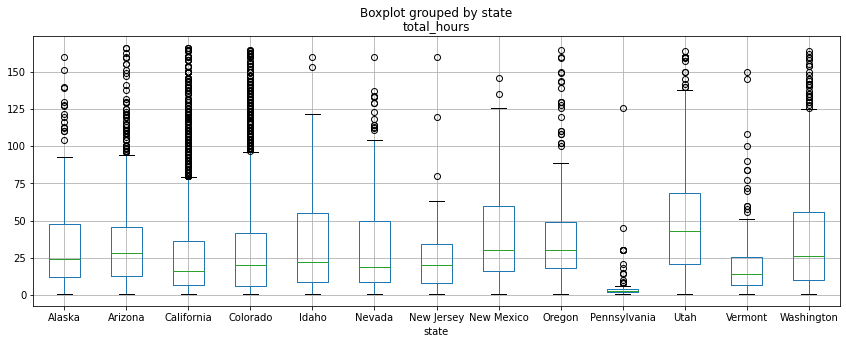

In [52]:
df.boxplot(column=['total_hours'], by='state', figsize=(14,5));

#### Dropping `state` outliers

In [53]:
drop_rows('Dropping outliers for "state"', 
          df[(df.state.isin(['Oregon', 'Utah'])) & (df.total_hours > 150) | 
             ((df.state.isin(['Alaska', 'Nevada', 'New Mexico'])) & (df.total_hours > 125)) | 
             ((df.state == 'Idaho') & (df.total_hours > 100)) | 
             ((df.state == 'Vermont') & (df.total_hours > 75)) | 
             ((df.state == 'New Jersey') & (df.total_hours > 50)) | 
             ((df.state == 'Pennsylvania') & (df.total_hours > 25))])

Dropping outliers for "state"
Number Rows Dropped: 60 - 0.4 %
Total Rows Dropped:  5781 - 34.9 %
Original Total Rows: 16574
Current Total Rows:  10793 



In [54]:
df.groupby('state')['total_hours'].describe().sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
Pennsylvania,121.0,3.231405,3.153729,1.0,1.00,2.0,4.00,21.0
Vermont,246.0,17.272358,14.311513,1.0,7.00,14.0,24.00,72.0
New Jersey,65.0,18.153846,12.661742,1.0,6.00,17.0,24.00,47.0
California,3202.0,27.999063,31.422452,1.0,7.00,16.0,36.00,166.0
Idaho,92.0,28.826087,27.207226,1.0,8.75,19.0,43.00,96.0
Colorado,3605.0,30.361442,32.535416,1.0,6.00,20.0,42.00,165.0
Nevada,348.0,30.379310,28.305962,1.0,9.00,18.0,46.25,123.0
Alaska,179.0,31.826816,28.206266,1.0,12.00,23.0,45.00,122.0
Arizona,1253.0,34.380686,29.044878,1.0,13.00,28.0,46.00,166.0


Observations
- This feature will be included in the classification models.
- Analysis and vizualization of this feature are conducted at the end of this notebook with all selected features after all drops have been made

---
---

# Area Type
- This variable describes the type of area and environment where the incident occured. This feature will be included in the classification models.
- Nulls will be imputed from several other related features. 

#### Creating two functions to impute `area_type` nulls based on a condition for 2 columns zipped together. 

In [55]:
def impute_nulls_specific(feat_dict, null_col, full_col):
    '''
    Imputes nulls between two variables. Requires defined 
    dictionary meant to replace nulls
    '''

    for key in feat_dict.keys():
        for val in feat_dict[key]:
            df[null_col] = [key if (pd.isna(null_col)) & (full_col == val)
                            else null_col
                            for null_col, full_col in zip(df[null_col], df[full_col])]
            
def impute_nulls_str_in(feat_dict, null_col, full_col):
    '''
    Imputes nulls between two variables. Requires defined 
    dictionary meant to replace nulls
    '''
    
    for key in feat_dict.keys():
        for val in feat_dict[key]:
            df[null_col] = [key if 
                                ((pd.isna(null_col)) and 
                                 (isinstance(full_col, str)) and 
                                 (val in full_col))
                            else null_col
                            for null_col, full_col in zip(df[null_col], df[full_col])]

#### Cleaning `area_type` to be lowercase replacing ' ' and 'other' with np.nan

In [56]:
df['area_type'] = [x.lower()if isinstance(x, str) else x for x in df['area_type']]
df['area_type'].replace(' ', np.nan, inplace=True)
df['area_type'].replace('other', np.nan, inplace=True)

## Area Type Other

#### Cleaning `area_type_other`
- Lowercasing all, replacing special characters with spaces. 
- Changing all values to 'interface' where 'interface' in string as these are area types that interface with wilderness

In [57]:
df['area_type_other'] = [x.lower().replace('-', ' ') if isinstance(x, str) 
                         else x
                         for x in df.area_type_other]

df['area_type_other'] = ['interface' if isinstance(x, str) and ('interface' in x)
                         else 'ski' if isinstance(x, str) and ('ski' in x)
                         else x
                         for x in df.area_type_other]

#### Comparing `area_type` vs. `type` , `area_type_other`,  and `category` to impute nulls

In [58]:
type_str = {'wilderness': ['avalanche', 'cave', 'forest', 'mountain'], 
            'water': ['water']}

type_specific = {'wilderness': ['rescue rock', 'rescue snow ice'], 
                 'rural': ['search rural'], 
                 'urban': ['search urban'], 
                 'water': ['dive rescue/recovery', 'flood']}
                  
area_type_other_specific = {'wilderness': ['desert', 'national forest', 'national park',
                                           'out of bounds mammoth mountain', 'state park', 'usfs'],
                            'interface': ['interface', 'beach', 'beach cliff', 'canyon road',
                                          'malibu creek state park',
                                          'mix of three area type, wilderness, rural, and private',
                                          'ranch', 'resort side country', 'ski']}

category_specific = {'wilderness': 
                          ['camping', 'climbing', 'hiking', 'hunting',
                           'mine_exploration', 'mountaineering', 'snowmobiling'], 
                     'water': 
                          ['boating', 'canoeing_kayaking_rafting', 'fishing', 'swimming'],
                     'interface':
                          ['snow shoeing', 'snow_skiing' 'snowboarding',
                           'four_wheel_driving', 'ohv/atv', 'horseback_riding', 'mtn bike'],
                     'rural': 
                          ['driving', 'motorcycling', 'motorized-land']}

impute_nulls_str_in(type_str, 'area_type', 'type')
impute_nulls_specific(type_specific, 'area_type', 'type')
impute_nulls_specific(area_type_other_specific, 'area_type', 'area_type_other')
impute_nulls_specific(category_specific, 'area_type', 'category')

#### Filling Nulls with "unknown"

In [59]:
df.area_type.fillna('unknown', inplace=True)

In [60]:
df[df.area_type == 'unknown'].shape[0]

563

### Grouping Suburban, Urban, & Rural
- These are all similar in the sense that they are closer to SAR teams, and their median total_hours are similar

In [61]:
df['area_type'] = ['urban_rural' if (x=='urban') | (x=='suburban') | (x=='rural') 
                   else x for x in df.area_type]

Observations
- This feature will be included in the classification models. 
- Analysis and visualizations for this feature are included at the end of this notebook with all selected features after all drops have been made

# Land Ownership
- This feature will be used to compare against `area_type` to impute nulls

#### Cleaning `land_ownership`

In [62]:
df['land_ownership'] = [x.lower().strip() if isinstance(x, str) else x for x in df.land_ownership]
df.land_ownership.replace('', np.nan, inplace=True)

#### Consolidating categories

In [63]:
df['land_ownership'] = ['forest, park, monument, blm' if 
                             (isinstance(x, str) and ('national' in x)) |
                             (isinstance(x, str) and ('blm' in x))
                         else 'private' if (isinstance(x, str) and ('private' in x))
                         else 'county' if (isinstance(x, str) and ('county' in x))
                         else 'city' if (isinstance(x, str) and ('city' in x))
                         else 'state' if (isinstance(x, str) and ('state' in x))
                         else x
                         for x in df.land_ownership]

In [64]:
df.land_ownership.head()

0                        private
1    forest, park, monument, blm
2                         county
3    forest, park, monument, blm
4    forest, park, monument, blm
Name: land_ownership, dtype: object

Observations
- This feature is similar to `area_type`. Since `area_type` has already been thoroghly imputed, `land_ownership` will not be included in the classification models. 

## Mileage

In [65]:
df.mileage.isna().sum()

3537

In [66]:
df.mileage.replace(0, np.nan, inplace=True)

In [67]:
df.sort_values(by='mileage')['mileage']

10017    1.0
9505     1.0
1161     1.0
2785     1.0
3832     1.0
        ... 
10786    NaN
10787    NaN
10789    NaN
10790    NaN
10791    NaN
Name: mileage, Length: 10793, dtype: float64

In [68]:
df.total_hours.corr(df.mileage)

0.3792346851740114

Observations
- This feature is almost 40% null
- This feature is not correlated with the Target timeframe. This feature will not be included in the classification models 

---
---

# Creating Children feature OHE
- Feature will be initiated as True where age of any of the 5 known subjects is <= 15

In [69]:
df['children'] = [1 if age <= 15 else 0 for age in df.age_sub_1]

for i in list(range(2, 6)):
    df['children'] = [1 if (children == 0) & (age <= 15)
                      else children 
                      for children, age in zip(df.children, df['age_sub_' + str(i)])]

#### Comparing `children` to `category` to impute nulls
- Many of the `category` inputs had "child" included somewhere in the string, meaning a child was involved.

In [70]:
df['children'] = [1 if ((children == 0) and (isinstance(cat, str)) and ('child' in cat))
                  else children 
                  for children, cat in zip(df.children, df.category)]

#### Addressing `children` outliers 

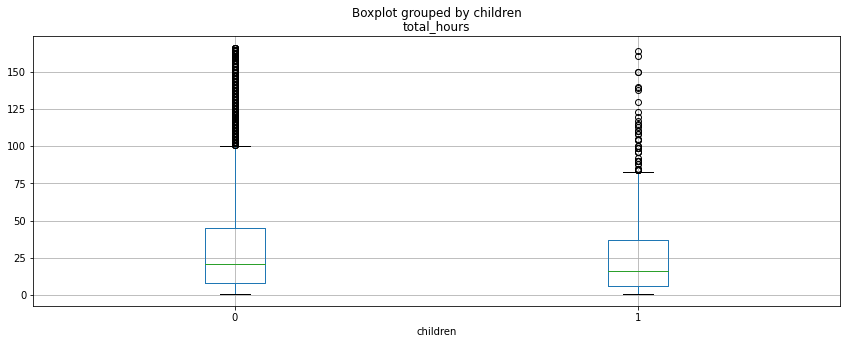

In [71]:
df.boxplot(column=['total_hours'], by='children', figsize=(14,5));

#### Dropping outliers for `children` = True

In [72]:
df[(df.children == 1) & (df.total_hours > 110)].shape[0]

14

In [73]:
drop_rows('"children" = True outliers', df[(df.children == 1) & (df.total_hours > 125)])

"children" = True outliers
Number Rows Dropped: 8 - 0.0 %
Total Rows Dropped:  5789 - 34.9 %
Original Total Rows: 16574
Current Total Rows:  10785 



In [74]:
df.groupby('children')['total_hours'].describe()

,count,mean,std,min,25%,50%,75%,max
children,,,,,,,,
0,10093.0,31.594570,32.106644,1.0,8.0,21.0,45.0,166.0
1,692.0,24.861272,25.393536,1.0,6.0,16.0,36.0,123.0


Observations
- Children make up a small portion of the entire dataset , but the average total time for these datapoints are significantly less than the average all those without children. 
- This feature will be included in the classification model. 

# Creating Senior feature
- Initiated `seniors` as True where age of any of the five known subjects is >= 65

In [75]:
df['seniors'] = [1 if age <= 15 else 0 for age in df.age_sub_1]

for i in list(range(2, 6)):
    df['seniors'] = [1 if (senior == 0) & (age >= 65)
                     else senior 
                     for senior, age in zip(df.seniors, df['age_sub_' + str(i)])]

#### Comparing `seniors` vs. subjects' "mental factor", specifically "dementia"
- "Dementia" suggest the victim is elderly. These datapoints will be imputed as True

In [76]:
df['seniors'] = [1 if ((seniors==0) and (isinstance(mental, str)) and (mental=='dementia'))
                 else seniors
                 for seniors, mental in zip(df.seniors, df.mental_factor_sub_1)]

df['seniors'] = [1 if ((seniors==0) and (isinstance(cat, str)) and (cat=='alzheimers_dementia'))
                 else seniors
                 for seniors, cat in zip(df.seniors, df.category)]

#### Addressing `seniors` outliers

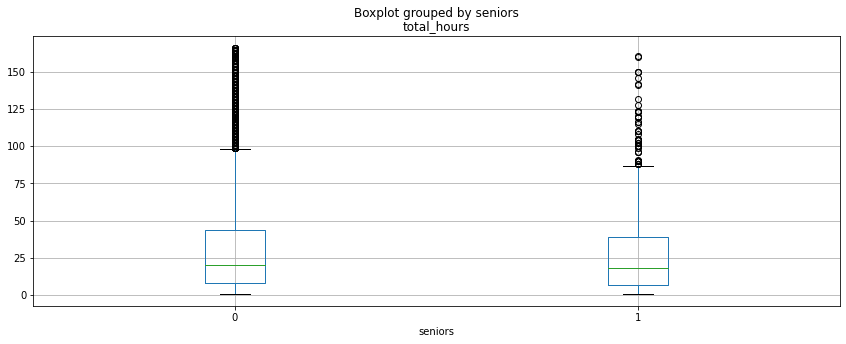

In [77]:
df.boxplot(column=['total_hours'], by='seniors', figsize=(14,5));

In [78]:
df[(df.seniors == 1) & (df.total_hours > 120)].shape[0]

14

#### Dropping outliers for `seniors` = True

In [79]:
drop_rows('"seniors" = True outliers', df[(df.seniors == 1) & (df.total_hours > 125)])

"seniors" = True outliers
Number Rows Dropped: 10 - 0.1 %
Total Rows Dropped:  5799 - 35.0 %
Original Total Rows: 16574
Current Total Rows:  10775 



In [80]:
df.groupby('seniors')['total_hours'].describe()

,count,mean,std,min,25%,50%,75%,max
seniors,,,,,,,,
0,9924.0,31.409512,31.909788,1.0,8.0,20.0,44.0,166.0
1,851.0,26.933020,27.126397,1.0,7.0,18.0,38.0,124.0


Observations
- Seniors make up a small portion of the entire dataset , but the average total time for these datapoints are significantly less than the average all those without children. 
- This feature will be included in the classification model. 

---
---

# Creating Mental feature OHE
- This feature will be True if any subjects had any "mental factor" present 

In [81]:
df['mental'] = [1 if isinstance(x, str) and (x != 'none')
                else 0
                for x in df.mental_factor_sub_1]

#### Comparing `mental` vs. `mental_factor_sub_2` to impute nulls
- If mental rating is not null and is not "normal", `mental` is True

In [82]:
for i in list(range(1, 6)):
    df['mental'] = [1 if ((mental==0) and (isinstance(rating, str)) and (rating != 'normal'))
                     else mental
                     for mental, rating in zip(df.mental, df['mental_rating_sub_' + str(i)])]

#### Comparing `mental` vs. `category` to impute nulls to True where "dementia" listed

In [83]:
df['mental'] = [1 if ((mental==0) and (isinstance(cat, str)) and (cat == 'alzheimers_dementia'))
                else mental
                for mental, cat in zip(df.mental, df.category)]

#### Addressing `mental` outliers

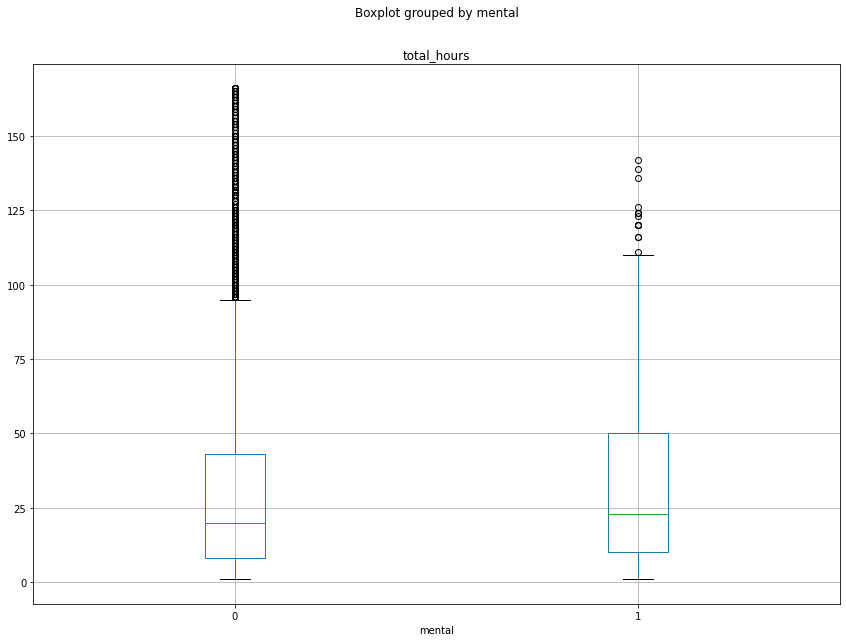

In [84]:
df.boxplot(column=['total_hours'], by='mental', figsize=(14,10));

#### Dropping outliers for `mental` True

In [85]:
drop_rows('"mental" = True outliers', df[(df.mental == 1) & (df.total_hours > 110)])

"mental" = True outliers
Number Rows Dropped: 15 - 0.1 %
Total Rows Dropped:  5814 - 35.1 %
Original Total Rows: 16574
Current Total Rows:  10760 



In [86]:
df.groupby('mental')['total_hours'].describe()

,count,mean,std,min,25%,50%,75%,max
mental,,,,,,,,
0,10287.0,30.929134,31.573397,1.0,8.0,20.0,43.0,166.0
1,473.0,30.864693,27.625114,1.0,10.0,22.0,46.0,110.0


Observations 
- This feature will be included in the classification models. 
- Analysis and visualizations for this feature are included at the end of this notebook with all selected features after all drops have been made

---
--- 

# Creating `daylight` feature to One Hot Encode
- daylight = 7am-8pm

In [87]:
df['daylight'] = [1 if 7 <= int(date[11:13]) <= 20 else 0 for date in df.date]

In [88]:
df.groupby('daylight')['total_hours'].describe()

,count,mean,std,min,25%,50%,75%,max
daylight,,,,,,,,
0,6474.0,31.067501,31.885158,1.0,8.0,20.0,44.0,166.0
1,4286.0,30.713019,30.678530,1.0,8.0,21.0,42.0,166.0


#### Addressing `daylight` outliers

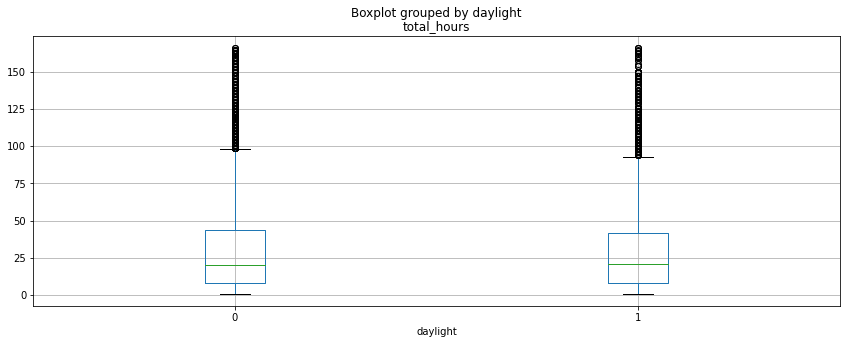

In [89]:
df.boxplot(column=['total_hours'], by='daylight', figsize=(14,5));

Observation
- There are many outliers for both group, but none are extreme and by themselves 
- Analysis and visualizations for this feature are included at the end of this notebook with all selected features after all drops have been made

# Creating `winter` feature OHE
- initially all datapoints in winter season (from `date`) will = 1
- after further feature analysis, datapoints outside of the winter season that pertain to winter conditions (events in snow) will be imputed as 1 (True) 

In [90]:
df['winter'] = [1 if 10 <= int(date[5:7]) <= 12 else 0 for date in df.date]

#### Comparing `winter` vs. `type`, `area_type_other`, `category`, `category_other`  to impute nulls

In [91]:
df['winter'] = [1 if ((winter == 0) & (typ == 'avalanche')) |
                     ((winter == 0) & (typ == 'rescue snow ice'))
                else winter
                for winter, typ in zip(df.winter, df.type)]

df['winter'] = [1 if ((winter == 0) & (typ == 'ski'))
                else winter
                for winter, typ in zip(df.winter, df.area_type_other)]

df['winter'] = [1 if ((winter == 0) and (isinstance(cat, str)) and ('snow' in cat))
                else winter
                for winter, cat in zip(df.winter, df.category)]

df['winter'] = [1 if ((winter == 0) and (isinstance(cat, str)) and ('ski' in cat)) |
                     ((winter == 0) and (isinstance(cat, str)) and ('snow' in cat)) 
                else winter
                for winter, cat in zip(df.winter, df.category_other)]

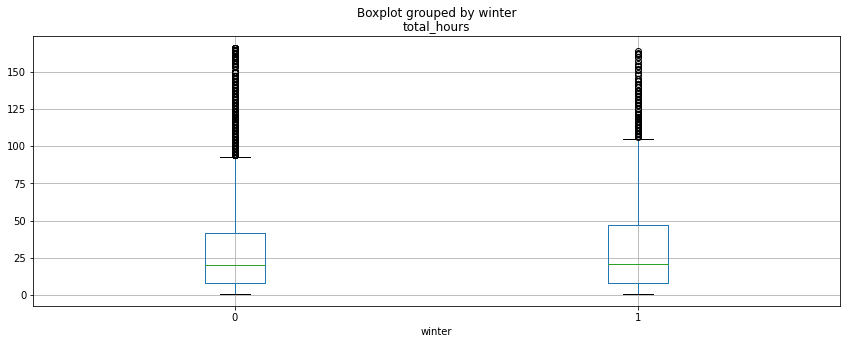

In [92]:
df.boxplot(column=['total_hours'], by='winter', figsize=(14,5));

In [93]:
df.groupby('daylight')['total_hours'].describe()

,count,mean,std,min,25%,50%,75%,max
daylight,,,,,,,,
0,6474.0,31.067501,31.885158,1.0,8.0,20.0,44.0,166.0
1,4286.0,30.713019,30.678530,1.0,8.0,21.0,42.0,166.0


Observations
- There are no extreme and isolated outliers
- The average and median for both of these feature are very close to one another. This feature will most likely not be very useful to our models. It will be included as the logistic regression model will use lasso and remove variables. Random Forest as a more complex model may have some use for this feature. 
- Further visualization and analysis of this feature are included below with all the selected features for the classification models. 

---
---

# Group Specifics
- This feature may be useful for imputing nulls for certain features. It explicitly describes specific details about the group of subjects. There are 27 unique values and 10870 nulls. 
- Otherwise it will not be included in my models

In [94]:
print('Null:', df.group_specifics.isna().sum())
print('Unique:', df.group_specifics.nunique())

Null: 10735
Unique: 25


#### Cleaning `group_specifics`

In [95]:
df['group_specifics'] = [x.lower().strip() if isinstance(x, str) 
                         else x 
                         for x in df.group_specifics]

---
---

# Aircraft Used

#### Cleaning `aircraft_used`
- Lowercase all strings, replacing "yes" with "aircraft-helicopter", and filling nulls with "no"

In [96]:
df['aircraft_used'] = [x.lower() if isinstance(x, str) else x for x in df.aircraft_used]
df.aircraft_used.replace('yes', 'aircraft-helicopter', inplace=True)
df.aircraft_used.replace(' ', np.nan, inplace=True)
df.aircraft_used.fillna('no', inplace=True)

#### Creating `total_aircrafts` 
- First creating OHE features for each aircraft type
- Summing 3 features into `total_aircrafts`

In [97]:
df['helicopter'] = [1 if 'helicopter' in x else 0 for x in df.aircraft_used]
df['uav'] = [1 if 'uav' in x else 0 for x in df.aircraft_used]
df['fixed_wing'] = [1 if 'fixed_wing' in x else 0 for x in df.aircraft_used]

df['total_aircrafts'] = df[['helicopter', 'uav', 'fixed_wing']].sum(axis=1)

In [98]:
df.groupby('total_aircrafts')['total_hours'].describe()

,count,mean,std,min,25%,50%,75%,max
total_aircrafts,,,,,,,,
0,8579.0,28.437930,29.498801,1.0,7.0,18.0,40.0,166.0
1,2149.0,40.413681,36.349158,1.0,12.0,30.0,59.0,166.0
2,32.0,60.906250,34.231997,11.0,31.5,56.5,79.5,126.0


#### Addressing `total_aircrafts` outliers

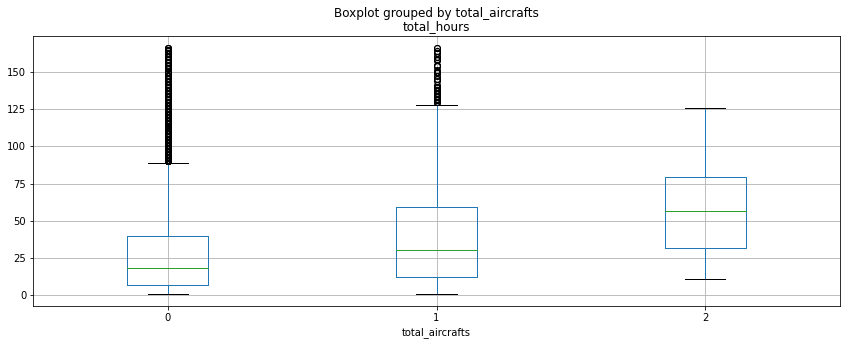

In [99]:
df.boxplot(column=['total_hours'], by='total_aircrafts', figsize=(14,5));

Observations
- As the number of types of aircrafts increases, the timeframe increases
    - This may be because aircrafts are used after a time. WHen people are lost for days, aircrafts are more likely to be employed
- There are no extreme and isolated outliers
- Further analysis and visualization is provided below with all the selected features for the classification models. 

## Aircraft Hours

In [100]:
df.aircraft_hours.fillna(0, inplace=True)

In [101]:
print(round(df[df.aircraft_hours == 0].shape[0] / df.shape[0] * 100), '% of dataset')

92 % of dataset


#### Total Aircrafts vs. Aircraft Hours

In [102]:
df[(df.total_aircrafts == 0) & (df.aircraft_hours > 0)].shape[0]

0

Observations
- 92% of the datapoints are null, and inconsistent with `total_aircrafts`
- This feature may also leak data to the models in predicting the target "time"

Action
- This feature is being dropped, as it is not as useful as `total_aircrafts` and may leak data into the models

In [103]:
df.drop('aircraft_hours', axis=1, inplace=True)

## Hoist Used
- dropping this feature as it describes an action that took place after victims were located

In [104]:
df.hoist_used.isna().sum()

9801

In [105]:
df.hoist_used.value_counts()

NO     546
YES    413
Name: hoist_used, dtype: int64

In [106]:
df.drop('hoist_used', axis=1, inplace=True)

---
---

# Team

#### Cleaning `team`

In [107]:
df['team'] = [x.lower().replace('_', ' ') if isinstance(x, str) else x for x in df.team]

In [108]:
df.team.nunique()

77

In [109]:
df.drop('team', axis=1, inplace=True)

### Team 

Observations
- This feature had 83 unique "teams" and will not be included in the classification models. It is being dropped.

# Lead Agency 
- This feature is 90% null and will be dropped

In [110]:
df.lead_agency.value_counts(dropna=False, normalize=True)

NaN    0.913848
NO     0.056320
YES    0.029833
Name: lead_agency, dtype: float64

In [111]:
df.drop('lead_agency', axis=1, inplace=True)

# Mutual Aid

#### Cleaning `mutual_aid`

In [112]:
df['mutual_aid'] = [x.lower()if isinstance(x, str) else x for x in df.mutual_aid]

In [113]:
df.mutual_aid.value_counts(dropna=False).sort_index()

no     4594
yes    2358
NaN    3808
Name: mutual_aid, dtype: int64

In [114]:
df.groupby('mutual_aid')['total_hours'].mean()

mutual_aid
no     28.285372
yes    33.515267
Name: total_hours, dtype: float64

Obersvations
- More than 1/3 of the dataset is null for this feature. 
- `number_volunteers` is somewhat related to this feature and is being included in the classification models. 
- This feature is being dropped

In [115]:
df.drop('mutual_aid', axis=1, inplace=True)

# Primary Area

In [116]:
df['primary_area'] = [x.lower() if isinstance(x, str) else x for x in df.primary_area]
df['primary_area'].replace(' ', 'Null', inplace=True)
df['primary_area'].fillna('Null', inplace=True)

df.primary_area.value_counts(dropna=False)

yes           5935
Null          2873
wilderness    1041
no             684
rural          143
suburban        35
urban           30
water           19
Name: primary_area, dtype: int64

In [117]:
df.groupby('primary_area')['total_hours'].describe().sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
primary_area,,,,,,,,
rural,143.0,26.090909,30.313366,1.0,5.00,15.0,36.50,154.0
urban,30.0,26.333333,30.659794,1.0,5.25,10.5,42.50,110.0
suburban,35.0,26.542857,24.769933,1.0,5.50,20.0,42.00,82.0
water,19.0,29.157895,36.887612,3.0,6.50,15.0,40.50,160.0
yes,5935.0,29.737321,30.487267,1.0,8.00,20.0,42.00,166.0
wilderness,1041.0,30.054755,31.058349,1.0,8.00,20.0,40.00,166.0
Null,2873.0,32.861817,31.990011,1.0,9.00,22.0,47.00,166.0
no,684.0,35.925439,36.530963,1.0,9.00,23.0,51.25,166.0


In [118]:
df.drop('primary_area', axis=1, inplace=True )

Observation
- It is unclear where this means it is the primary area of the SAR Team
- `area_type` is already being included in the classification models, and seams to be overlapping with this feature. 
- This feature is being dropped from the dataset

---
---

# Creating GPS feature where gps locater used

## Accidental Transmitter
- This feature describes incidents when a transmitter was used, and whether it was an accident. 

#### Creating `gps`  initially from `accidental_transmitter`
- Initiated as True if `accidental_transmitter` is not null

In [119]:
df['gps'] = [1 if pd.notnull(gps) else 0 
             for gps in df.accidental_transmitter]

#### Comparing `gps` vs. `type` to correct nulls
- Emergency Locator Transmitter a.k.a. ELT
- Personal Locator Beacon a.k.a. PLB

In [120]:
df['gps'] = [1 if ((gps==0) and (isinstance(typ, str)) and (typ == 'plb activation')) |
                  ((gps==0) and (isinstance(typ, str)) and (typ == 'send activation'))
             else gps
             for gps, typ in zip(df.gps, df.type)]

In [121]:
df.gps.value_counts(dropna=False)

0    10651
1      109
Name: gps, dtype: int64

#### Addressing `gps` outliers

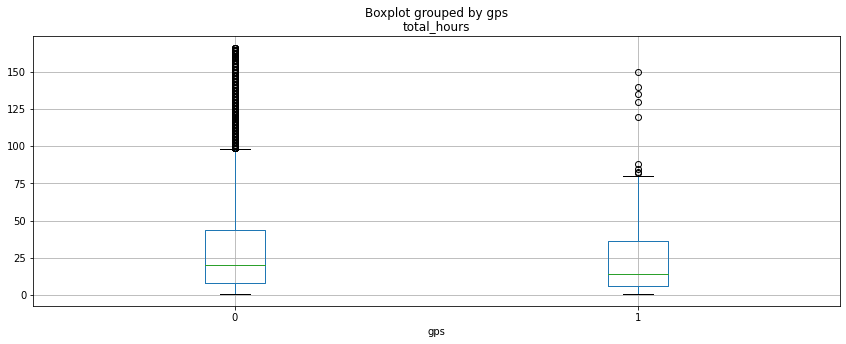

In [122]:
df.boxplot(column=['total_hours'], by='gps', figsize=(14,5));

In [123]:
df[(df.gps == 1) & (df.total_hours > 75)].shape[0]

10

In [124]:
drop_rows('"gps" = True outliers', 
          df[(df.gps == 1) & (df.total_hours > 75)])

"gps" = True outliers
Number Rows Dropped: 10 - 0.1 %
Total Rows Dropped:  5824 - 35.1 %
Original Total Rows: 16574
Current Total Rows:  10750 



In [125]:
df.groupby('gps')['total_hours'].describe()

,count,mean,std,min,25%,50%,75%,max
gps,,,,,,,,
0,10651.0,30.958032,31.398867,1.0,8.0,20.0,44.0,166.0
1,99.0,19.595960,18.379736,1.0,6.0,12.0,29.0,75.0


Observations
- This feature is null for 98% of the dataset
- It is very interesting how short the timeframe is for those incidents where a transmitter was used. This feature will not be used in the classification models, but it will be included in the presentation, because it clearly shows how short the timeline becomes when a transmitter is used. 

 ## Summary of all rows dropped
 - This is a summary of all the rows dropped while cleaning this dataset to only include trey, typical Search and Rescue mission where at least one live victim was being located and rescued. 
 - A total of 35% of the dataset was dropped. 
 - The cleaned dataset includes 10,761 datapoints, and will be sufficient for modeling. 

In [126]:
rows_dropped()

,num_dropped,perc_data,total_rows
Original Dataset,0.0,0.0,16574.0
"""type"" that aren't true SAR missions",1608.0,9.7,14966.0
"""category"" that aren't true SAR missions",553.0,3.3,14413.0
"""category_other"" that aren't true SAR missions",111.0,0.7,14302.0
"""total_hours"" are Null",678.0,4.1,13624.0
"""total_hours"" > 168 (7 days)",659.0,4.0,12965.0
"""date"" <= 2014",46.0,0.3,12919.0
"""age_sub_1"" > 92",5.0,0.0,12914.0
"""number_subjects"" > 10",31.0,0.2,12883.0
"""number_subjects"" = 0",1192.0,7.2,11691.0


---
---

# Data Analysis

### Creating a function to plot a feature vs. the target, the distribution, and median total_hours

In [127]:
def prop_dist_graph_2(feat, height=10, height_2=6):
    '''
    Returns 4 plots: 
        Target vs. Feature (stacked bar chart)
        Feature vs. Target (stacked bar chart)
        Feature Distribution (stacked bar chart)
        Median total hours for feature categories (bar chart)
    '''

    fig, ax = plt.subplots(3,1, figsize=(10,height))

    df.groupby('time_bin')[feat].value_counts(normalize=True)\
            .unstack().plot(kind='barh', 
                            cmap='BrBG',
                            alpha=0.7,
                            stacked=True,
                            ax=ax[0])
    ax[0].set_title('Target time_bin vs. ' + feat,
                 fontsize=14, 
                 fontweight='bold', 
                 color='firebrick', 
                 loc='left', 
                 pad=10)
    ax[0].set_ylabel('time_bin', weight='bold')
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    var_order = df[feat].value_counts().sort_values(ascending=False).index.tolist()
    df.groupby(feat)['time_bin'].value_counts(normalize=True).unstack().loc[var_order].T\
       .loc[['0-11hr', '11-32hr', '32hours-7day']].T\
        .plot(kind='barh', 
                        stacked=True,
                        cmap='BrBG',
                        alpha=0.8,
                        ax=ax[1]);
    ax[1].set_title(feat + ' vs. Target time_bin',
                 fontsize=14, 
                 fontweight='bold', 
                 color='firebrick', 
                 loc='left', 
                 pad=10)
    ax[1].set_ylabel(feat, weight='bold')
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
    df[feat].value_counts(dropna=False, normalize=True).sort_values(ascending=False)\
    .plot(kind='barh',
          color='darkcyan',
          alpha=0.7,
          ax=ax[2])
    ax[2].xaxis.set_ticks(np.arange(0, 1.1, .1))    
    ax[2].set_title('"' + feat + '" Distribution',
                 fontsize=15, 
                 fontweight='bold', 
                 color='firebrick', 
                 loc='left', 
                 pad=10)
    ax[2].set_ylabel(feat, weight='bold')
    plt.tight_layout();

    # this subplot is separate from the above to allow separate sizing func arg's 
    fig, ax = plt.subplots(figsize=(10,height_2))
    
    df.groupby(feat)['total_hours'].median().to_frame().loc[var_order].plot(kind='barh',
                                                  fontsize=11,
                                                  color='darkcyan',
                                                  alpha=0.7,
                                                  ax=ax)
    
    ax.set_title(feat + ' vs. Target time_bin',
                 fontsize=14, 
                 fontweight='bold', 
                 color='firebrick', 
                 loc='left', 
                 pad=10)
    ax.set_xlabel('Average total_hours', weight='bold')
    ax.set_ylabel(feat, weight='bold')


    
    ax.get_legend().remove()
    max_width = 0
    for rect in ax.patches:
        if rect.get_width()>max_width:
            max_width = rect.get_width()
    
    for rect in ax.patches:

            height = rect.get_height()
            width = rect.get_width()
            x = rect.get_x()
            y = rect.get_y()
            
            label_text = round(width, 2)
            
            label_x = x + width / 2
            label_y = y + height / 2

            if label_x < max_width*.05:
                ax.text(width+.05*max_width, label_y, f'{label_text:.2f}'
                        , ha='center', va='center', color = 'black')
            else:
                ax.text(label_x, label_y, f'{label_text:.2f}'
                        , ha='center', va='center', color = 'black', weight='bold', size=12)
    plt.tight_layout();  

# Time
- `total_hours` will be binned into 3 groups
    - 0-12 hours, 12-24 hours, 1-7 days
- The first 24 hours are critical to the survival rate of victims in need of being rescued. Hypothermia occurs more often than one might expect. A single night in the ourdoors can ultimately lead to diminished capacity, reduced ability to actively participate in the search efforts of SAR teams, and potentially death. 
- These time bins are selected for these reasons listed above. It would be beneficial for SAR teams and particularly individuals who enjoy the outdoors to understand what contributes to the success of a SAR mission. 

In [128]:
df['time_bin'] = pd.cut(df['total_hours'], 
                        bins=[0,11,32,168], 
                        labels=['0-11hr', '11-32hr', '32hours-7day'])

df.time_bin.value_counts(normalize=True).sort_values(ascending=False)

32hours-7day    0.342605
0-11hr          0.331442
11-32hr         0.325953
Name: time_bin, dtype: float64

## Baseline Model - 35% for the majority class (32hours-7 days)

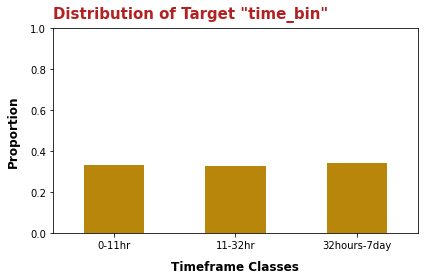

In [129]:
fig, ax = plt.subplots(figsize=(6, 4))

df['time_bin'].value_counts(normalize=True).sort_index().plot(kind='bar', 
                                                              ax=ax, 
                                                             color='darkgoldenrod')

ax.set_title('Distribution of Target "time_bin"',
             fontsize=15, 
             fontweight='bold', 
             color='firebrick', 
             loc='left', 
             pad=10)

ax.set_ylabel('Proportion', weight='bold', labelpad=10, fontsize=12)
ax.set_xlabel('Timeframe Classes', weight='bold', labelpad=10, fontsize=12)
plt.xticks(rotation=0)
plt.ylim([0,1])

plt.tight_layout()

#### Target Timeframe
Observation
- The majority class is 32 hours to 7 days at 35%
- The classes are equally distributed 

# Number Subjects

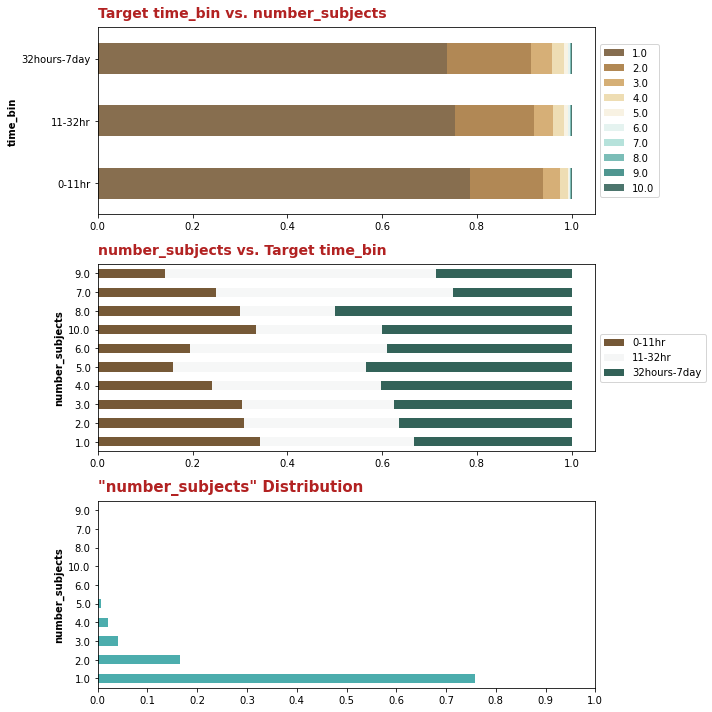

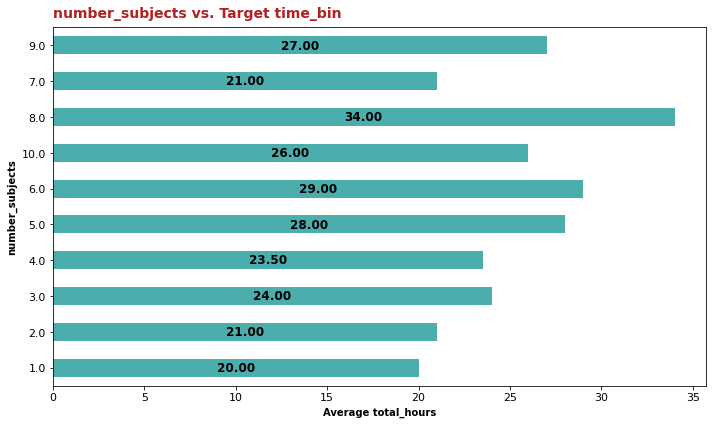

In [130]:
prop_dist_graph_2('number_subjects')

In [131]:
df.number_subjects.value_counts()

1.0     8159
2.0     1777
3.0      438
4.0      224
5.0       76
6.0       36
10.0      15
8.0       10
7.0        8
9.0        7
Name: number_subjects, dtype: int64

### Number Subjects
Observations
- Incidents with only one subject are the most fequent category. Contrary to what I expected, incidents with only one victim actually have the lowest median total_hours. 
- Coincidentally as the number of subjects increase, so does the time it takes to get rescued. This is contrary to what I would expect. It would make sense that the more subjects involved, the easier it would be for SAR teams to locate them. 
- When analyzing this feature against the average `total_hours`, there does not seem to be a significant difference for each category. 
- I am going to include this feature in the classification models, though I don't expect it to be as indicative as the other included features.  

# Total Aircrafts

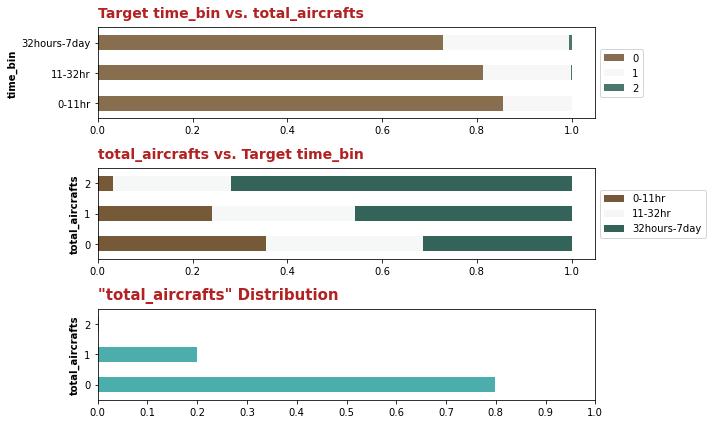

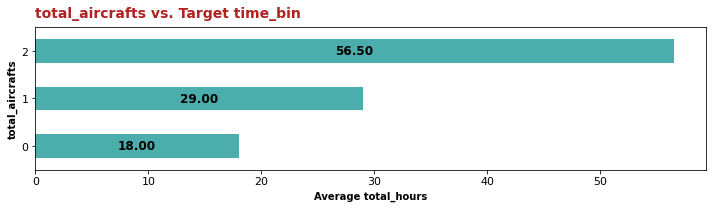

In [132]:
prop_dist_graph_2('total_aircrafts', 6, 3)

In [133]:
df.total_aircrafts.value_counts()

0    8575
1    2143
2      32
Name: total_aircrafts, dtype: int64

In [134]:
df[df.uav == 1].shape[0]

52

### Total Aircrafts
Observations
- This feature is a count of the total number of different types of aircrafts used in the SAR mission. 
    - helicopter, fixed-wing, UAV
- It makes sense that the more aircrafts used, the longer the SAR mission. Aircrafts may be dispatched later on in the SAR mission to aid in the search efforts. 
    - it would seem that employing aircrafts does decrease the timeframe as they are called out to aid SAR missions after a certain amount of time the persons are lost
- 20% of the dataset include 1 type of aircraft, and only 33 datapoints include 2 types of aircrafts. The later will not be as useful in our models as a dummy variable, but we will include it and let lasso decide the usefulness of the feature. 
- Only 52 datapoints used UAVs. This seems like an area that should be explored by SAR teams as the technology is advancing at a fast pace currently. 

# Area Type

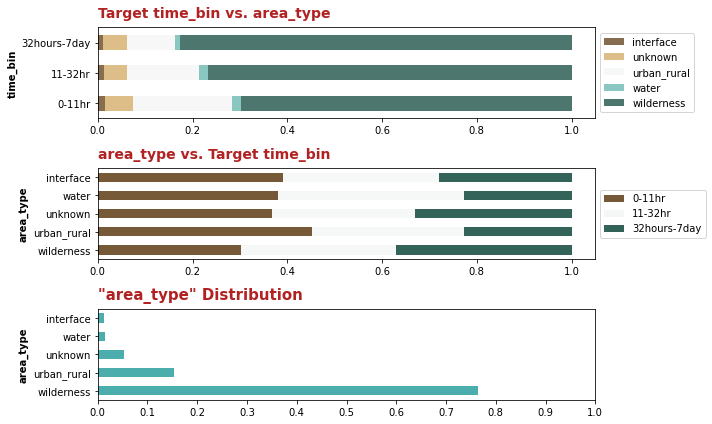

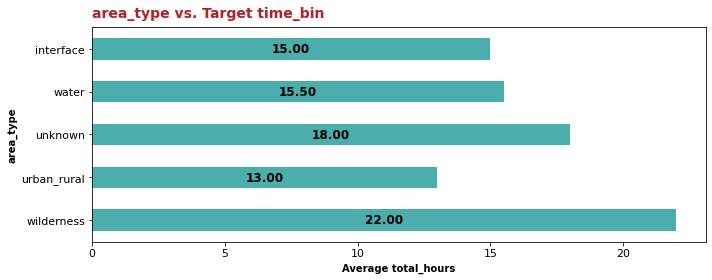

In [135]:
prop_dist_graph_2('area_type', 6, 4)

In [136]:
df.area_type.value_counts()

wilderness     8221
urban_rural    1657
unknown         561
water           168
interface       143
Name: area_type, dtype: int64

## Area Type
Observations
- 76% of the datapoints are in the wilderness. Understandably, these incidents have the highest average total_hours. 
- urban and rural incidents have the lowest median total_hours. 
- This feature will be dummied in the preprocessing notebook and included in my models. 
- As wilderness incidents have the longest average timeframe, this is the area type that requires the most attention for improvement. 

# Winter

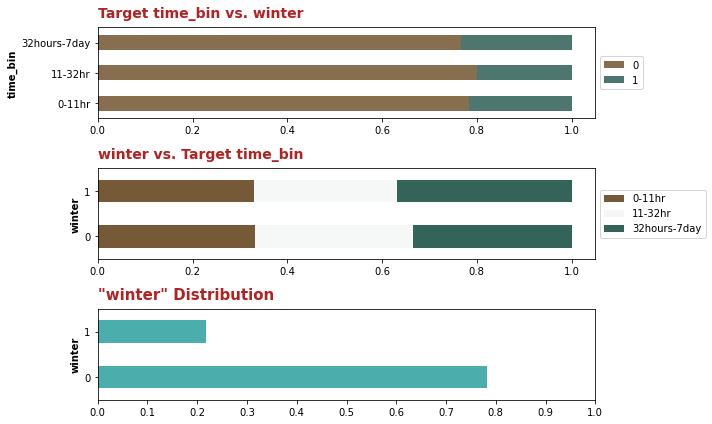

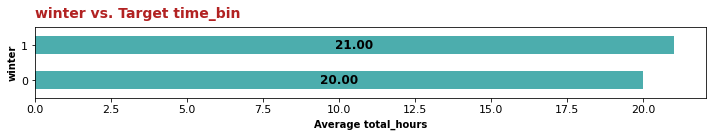

In [137]:
prop_dist_graph_2('winter', 6, 2)

### Winter
Observations
- This feature describes incidents that occured in winter or in snow. 
- There appears to be no difference in median or average time between the two categories. I will include this feature in the classification models though it will most likely not be significant. The logistic regression model will use lasso and most likely drop this feature. The Random Forest model is more complex and may find some use for this feature. 

# Mental

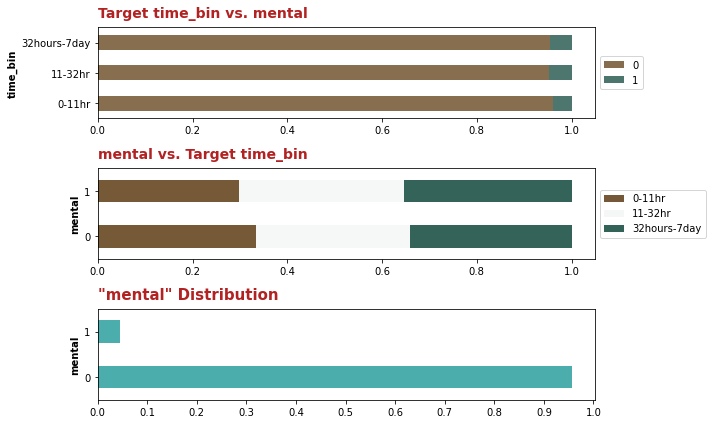

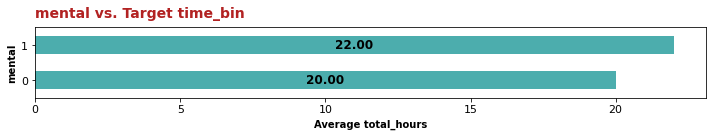

In [138]:
prop_dist_graph_2('mental', 6, 2)

### Mental 
Observations
- This is a OHE feature that is True if any subject as any mental condition or rating. 
- There is a slight increase in the average time it takes to complete a SAR mission when there is a mental factor present in any of the victims, as expected. 
- This feature will be included in the classification models

# Seniors

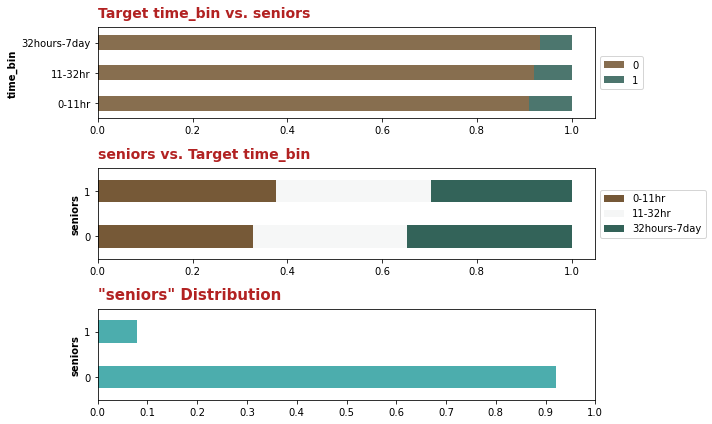

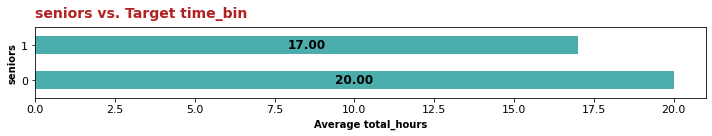

In [139]:
prop_dist_graph_2('seniors', 6, 2)

In [140]:
df[df.seniors == 1]['area_type'].value_counts()

urban_rural    378
wilderness     366
unknown         79
water           14
interface        5
Name: area_type, dtype: int64

### Seniors
Observations
- This is a OHE feature that is True if any of the subjects are 65 or older. 
- Less than 1% of the dataset include seniors.
- Contrary to what I expected, incidents with seniors get rescued faster. There is an equal amount of urban/rural incidents as wilderness incidents. This could be the cause of this effect. 
- I will include this feature in the classification models. 

# Children

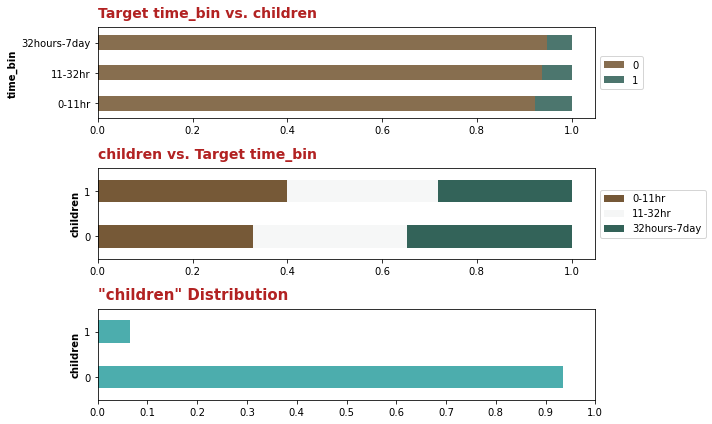

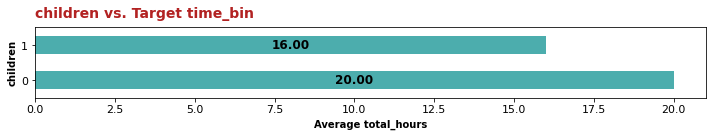

In [141]:
prop_dist_graph_2('children', 6, 2)

### Children 
Observations
- If any children 15 or younger are involved in an incident, this feature is True. 
- Less than 1% if the dataset include children, but those that do have considerably lower total hours. 
- I will include this feature in the classification models. 

# State

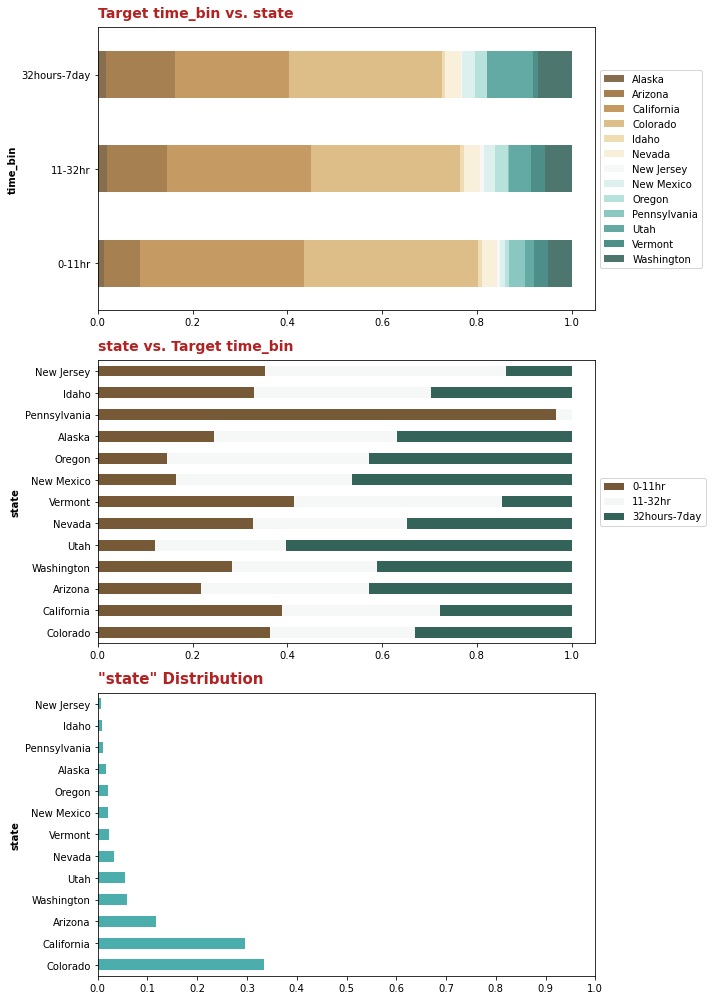

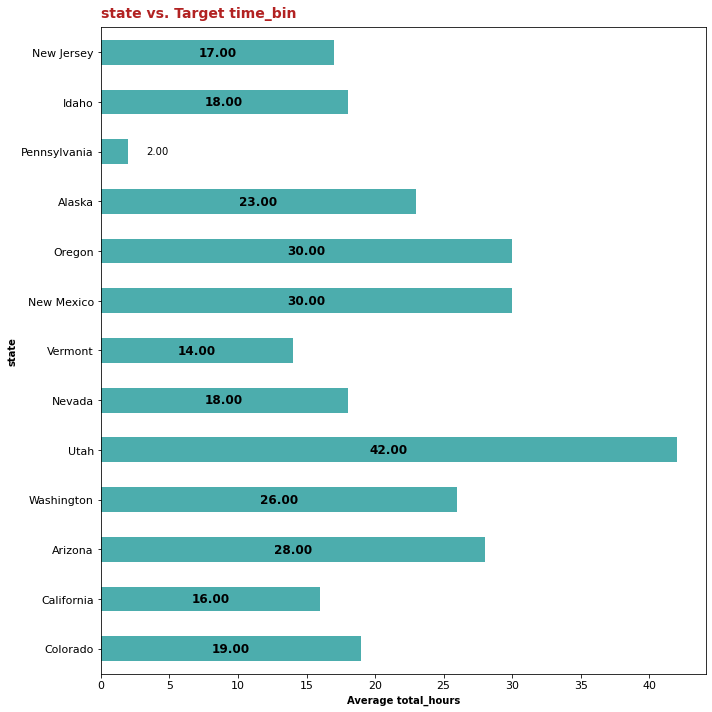

In [142]:
prop_dist_graph_2('state', 14, 10)

### State
- I included State as a feature instead of Team which had over 80 unique teams. 
- There are significant differences in average total_hours between all the different states. 
- California and Colorado consist of over 60% of the entire dataset, and both have pretty low average total_hours. 
    - These states most likely have highly experienced SAR teams and possibly a higher level of government funding and support
- I will dummify this feature and include them in the classification models. 

# Number Volunteers

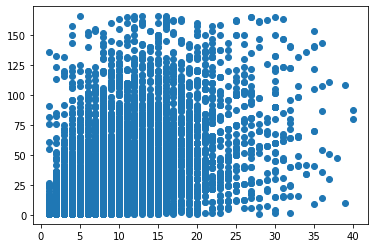

In [143]:
plt.scatter(x='number_volunteers', y='total_hours', data=df);

In [144]:
df.total_hours.corr(df.number_volunteers)

0.5119496585659512

### Number Volunteers
Observations 
- I expected this feature to have a higher correlation with the target variable total_hours. 
- Since it is one of the only actual continuous variables in the dataset, I will include it in the classification models, though lasso may not keep the feature. 

# Exporting Cleaned Dataframe

In [145]:
df.to_csv('../Data/cleaned_data.csv', index=False)


In [146]:
rows_dropped_df = pd.DataFrame(rows_dropped_dict).T
rows_dropped_df.rename(columns={0:'num_dropped'}, inplace=True)
rows_dropped_df.drop(labels=[1,2], axis=1, inplace=True)

rows_dropped_df.to_csv('../Data/rows_dropped_df.csv')